In [1]:
import tensorflow as tf
import numpy as np
import sys

from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler
#from sklearn.preprocessing import MinMaxScaler ##########

sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
#sys.path.append('/Users/Think/Desktop/project')

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression

#Data handlers
from ann_framework.data_handlers.data_handler_Oscillator import OscillatorDataHandler

#Custom modules
from ann_framework import aux_functions

import aux_functions_stochastic
import analytic_functions
import loss_functions


Using TensorFlow backend.


In [2]:
#global variables

deltas = [0.1, 0.1]

k = 1
c = 0.1
D = 1
num_fevals = 5

sigma_x = np.sqrt(D / (k * c))
sigma_y = np.sqrt(D / c)

### Define tensorflow model

In [3]:
def create_placeholders(input_shape, output_shape):
    
    X = tf.placeholder(tf.float32, shape=(None,input_shape), name="X")
    y = tf.placeholder(tf.float32, shape=None, name="y")
    
    return X, y

"""
def tf_model(X):
    
    l2_lambda_regularization = 0.20
    l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), 
                         name="fc1")
    A2 = tf.layers.dense(A1, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc2")
    y = tf.layers.dense(A2, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="out")
    
    return y
"""

def tf_model_yulin(X):
    
    A1 = tf.layers.dense(X, 30, activation=tf.nn.tanh, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),name="fc1")
    A2 = tf.layers.dense(A1, 30, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),name="fc2")
    """
    A3 = tf.layers.dense(A2, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc3")
    dropout3 = tf.layers.dropout(inputs = A3, rate = 0.2)
    A4 = tf.layers.dense(dropout3, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc4")
    dropout4 = tf.layers.dropout(inputs = A4, rate = 0.2)
    """
    y = tf.layers.dense(A2, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        name="out")
    #activation funcs
    
    return y


### Create Model TF

In [4]:
def tf_compiled_model(num_features, output_shape):
    tf.reset_default_graph()

    X, y = create_placeholders(num_features, output_shape)

    #y_pred = tf_model(X)
    y_pred = tf_model_yulin(X)
    
    loss_function = loss_functions.squared_residual_function_wrapper2(k, c, D, deltas, num_fevals, sigma_x, sigma_y)
    cost, e = loss_function(X, y_pred, y)
    #reg_cost = tf.losses.get_regularization_loss()
    total_cost = e
    
    # total_cost: e
    # cost: R
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.5).minimize(total_cost)

    return {'X_placeholder': X, 'y_placeholder': y, 'y_pred': y_pred, 'cost': cost, 'total_cost': total_cost, 'optimizer': optimizer}

### Create Tunable Model Tensorflow and assign data

In [5]:
#scaler = MinMaxScaler()

dhandler_stochastic = OscillatorDataHandler()

#(data_scaler = scaler)

model = tf_compiled_model(2, 1)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_stochastic)

tModel.load_data(verbose=1, cross_validation_ratio=0.2, x=[0, 0], boundaries=[10, 10], n=[50, 50])

#Real phi function
p_real_test, phi_real_test = analytic_functions.real_p(tModel.X_test[:,0], tModel.X_test[:,1], sigma_x, sigma_y)
p_real_train, phi_real_train = analytic_functions.real_p(tModel.X_train[:,0], tModel.X_train[:,1], sigma_x, sigma_y)
p_real_crossVal, phi_real_crossVal = analytic_functions.real_p(tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], sigma_x, sigma_y)

tModel.y_test = phi_real_test
tModel.y_train = phi_real_train
tModel.y_crossVal = phi_real_crossVal


tModel.print_data()

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

Loading data. Cros-Validation ratio 0.2
Printing shapes

Training data (X, y)
(7200, 2)
(7200, 1)
Cross-Validation data (X, y)
(1800, 2)
(1800, 1)
Testing data (X, y)
(1000, 2)
(1000, 1)
Printing firs

/Users/davidlaredorazo/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train model Tensorflow

In [6]:
tModel.epochs = 200
#lrate = LearningRateScheduler(aux_functions.step_decay)
minibatches_function_handle = aux_functions_stochastic.get_minibatches

#tf.get_variable("deltas", initializer=deltas)

sess = tf.Session()

#writer = tf.summary.FileWriter('./graphs', sess.graph)

tModel.train_model(tf_session=sess, get_minibatches_function_handle=minibatches_function_handle, 
                   verbose=1, deltas=deltas)

    # cost_reg: total_cost -> e
    # cost: R

Epoch: 0001 cost_reg= 3.821564515 cost= 0.724952513
Epoch: 0002 cost_reg= 1.412211728 cost= 1.259008942
Epoch: 0003 cost_reg= 0.839262625 cost= 2.189930244
Epoch: 0004 cost_reg= 0.450303962 cost= 3.961745626
Epoch: 0005 cost_reg= 0.330784861 cost= 4.999961611
Epoch: 0006 cost_reg= 0.306769600 cost= 5.202972535
Epoch: 0007 cost_reg= 0.236344520 cost= 5.440280179
Epoch: 0008 cost_reg= 0.221943870 cost= 5.326750640
Epoch: 0009 cost_reg= 0.184438237 cost= 5.458279896
Epoch: 0010 cost_reg= 0.188859553 cost= 5.587948545
Epoch: 0011 cost_reg= 0.164330860 cost= 5.610766298
Epoch: 0012 cost_reg= 0.133315718 cost= 5.751281782
Epoch: 0013 cost_reg= 0.218614241 cost= 5.799998502
Epoch: 0014 cost_reg= 0.131564566 cost= 5.785299643
Epoch: 0015 cost_reg= 0.117913800 cost= 5.913748630
Epoch: 0016 cost_reg= 0.147631101 cost= 5.969352027
Epoch: 0017 cost_reg= 0.103164011 cost= 6.006382751
Epoch: 0018 cost_reg= 0.237277947 cost= 5.965060298
Epoch: 0019 cost_reg= 0.082637723 cost= 6.105739804
Epoch: 0020 

Epoch: 0159 cost_reg= 0.059589397 cost= 7.914743157
Epoch: 0160 cost_reg= 0.006597833 cost= 7.934186657
Epoch: 0161 cost_reg= 0.014384297 cost= 7.934481506
Epoch: 0162 cost_reg= 0.003647792 cost= 7.989444258
Epoch: 0163 cost_reg= 0.011448928 cost= 7.987491628
Epoch: 0164 cost_reg= 0.011361290 cost= 7.993173039
Epoch: 0165 cost_reg= 0.022908699 cost= 7.974465883
Epoch: 0166 cost_reg= 0.008263423 cost= 7.996060348
Epoch: 0167 cost_reg= 0.015349058 cost= 8.002810081
Epoch: 0168 cost_reg= 0.018623236 cost= 8.010927403
Epoch: 0169 cost_reg= 0.073595649 cost= 7.823089548
Epoch: 0170 cost_reg= 0.012830713 cost= 7.881934365
Epoch: 0171 cost_reg= 0.004941408 cost= 7.959986790
Epoch: 0172 cost_reg= 0.004376658 cost= 7.997151987
Epoch: 0173 cost_reg= 0.011029538 cost= 7.995356139
Epoch: 0174 cost_reg= 0.053194575 cost= 7.952046406
Epoch: 0175 cost_reg= 0.012490864 cost= 7.870536302
Epoch: 0176 cost_reg= 0.004033353 cost= 7.953472384
Epoch: 0177 cost_reg= 0.007852315 cost= 7.988360363
Epoch: 0178 

In [7]:
display_points = 50

"""
#Evaluate real model
X_test = tModel.X_crossVal

#Real phi function
sigma_x = np.sqrt(D / (k * c))
sigma_y = np.sqrt(D / c)
p_real, phi_real = analytic_functions.real_p(X_test[:,0], X_test[:,1], sigma_x, sigma_y)

tModel.y_crossVal = phi_real

#p_real = np.ravel(p_real)
#phi_real = np.ravel(phi_real)

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
#phi_pred = np.ravel(tModel.y_predicted)
phi_pred = tModel.y_predicted

d = 2 * np.pi * sigma_x * sigma_y
c_not = 1/d
p_pred = c_not * np.exp(-phi_pred)
"""

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
phi_pred = tModel.y_predicted
phi_real = tModel.y_crossVal
print("scores")

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(phi_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)

phi_real_sampled = phi_real[sample_points]
phi_pred_sampled = phi_pred[sample_points]
X_sampled = X_test[sample_points,:]

i = range(len(phi_pred_sampled))


for i, phi_real_display, phi_pred_display in zip(i, phi_real, phi_pred):
    print('xy {}, Real Phi {}, Predicted Phi {}'.format(X_test[i], phi_real_display, phi_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

scores
xy [-0.1010101  9.5959596], Real Phi [4.60463218], Predicted Phi [4.4323034]
xy [ 9.7979798  -2.52525253], Real Phi [5.11886542], Predicted Phi [4.933442]
xy [ 8.18181818 -3.13131313], Real Phi [3.83736353], Predicted Phi [3.8281047]
xy [-8.78787879 -1.11111111], Real Phi [3.92306907], Predicted Phi [4.015305]
xy [-0.50505051 -8.78787879], Real Phi [3.87409448], Predicted Phi [4.005671]
xy [3.13131313 7.77777778], Real Phi [3.51494745], Predicted Phi [3.4640448]
xy [-8.38383838 -4.54545455], Real Phi [4.54749515], Predicted Phi [4.688562]
xy [-9.39393939  3.13131313], Real Phi [4.90256096], Predicted Phi [4.780583]
xy [0.90909091 1.71717172], Real Phi [0.18875625], Predicted Phi [0.15626502]
xy [2.12121212 8.78787879], Real Phi [4.08631772], Predicted Phi [4.052517]
xy [8.38383838 9.7979798 ], Real Phi [8.31445771], Predicted Phi [8.189778]
xy [-8.58585859 -7.77777778], Real Phi [6.71053974], Predicted Phi [7.034182]
xy [-8.98989899  5.95959596], Real Phi [5.81675339], Predicted

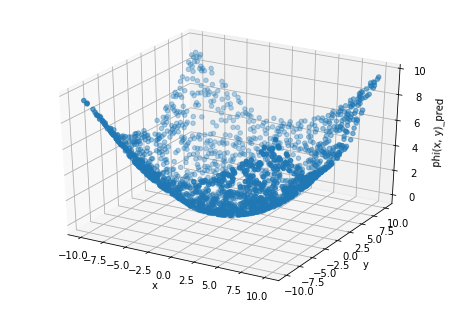

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure(1)
ax1 = Axes3D(fig1)
pred_phi_plot = Axes3D.scatter(ax1, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], phi_pred)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('phi(x, y)_pred')

plt.show()

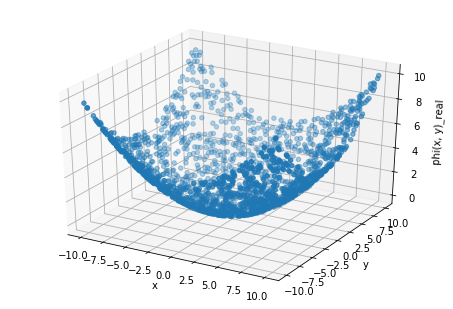

In [9]:
fig2 = plt.figure(2)
ax2 = Axes3D(fig2)
real_phi_plot = Axes3D.scatter(ax2, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], phi_real)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('phi(x, y)_real')

plt.show()

In [10]:
fig3 = plt.figure(3)
ax3 = Axes3D(fig3)
pred_p_plot = Axes3D.scatter(ax3, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], p_pred)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('p(x, y)_pred')

plt.show()

NameError: name 'p_pred' is not defined

In [ ]:
fig4 = plt.figure(4)
ax4 = Axes3D(fig4)
real_p_plot = Axes3D.scatter(ax4, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], p_real)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('p(x, y)_real')

plt.show()

In [ ]:
def real_derivatives(X, sigma_x, sigma_y):
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    first_order_dx = x1/(sigma_x**2)
    first_order_dy = x2/(sigma_y**2)
    second_order_dy = 1/(sigma_y**2)
    
    return first_order_dx, first_order_dy, second_order_dy

dx, dy, ddy = real_derivatives(X_test, sigma_x, sigma_y)

In [ ]:
dx, dy, ddy = analytic_functions.real_derivatives(tModel.X_crossVal, sigma_x, sigma_y)

#for i in range(len(dx)):
 #   print('dx {}, dy {}, ddy {}'.format(dx[i], dy[i], ddy[i]))